# CIFAR-10 Classification With Neuronal Network And Convolutional Layers

### written by Riccard Nef in Nov-Dec 2021

#### Description
- This Notebook was created for the competence Deep Learning for the course Data Science in Brugg for FHNW.
- This task will be done with Pytorch, there is no clear reason why not Tensorflow. 

## 1. Introduction
### 1.1 Challenge Description

Implement, train, and validate a neural network model for a
classification task with an appropriate dataset (e.g., motion classification with the Activity
Recognition Dataset). You can propose a suitable dataset - it should not be too
large (in order to be able to evaluate many different model and parameter variants,
but also not too small, so that still reasonable ML can be done. The focus of the
mini-challenge should be on the evaluation of the model variants and settings of the
hyperparameters. Furthermore, not too sophisticated complex model architectures should be
model architectures should be investigated. A MLP for the classification with a few CNN layers for
CNN layers for feature extraction should be sufficient.
If image data is used, you can also use transfer learning to extract features from the images.
features from the images and then explore them with MLPs. 

## 2. Data Analysis
### 2.0 Load Packages
- torch
- torchvision
- torchsummary

In [42]:
    import seaborn as sns
    import torch
    import torchvision
    from torchsummary import summary
    import torchvision.transforms as transforms
    import pandas as pd
    import collections
    import torch.nn as nn
    import torch.nn.functional as F
    #!pip install torchviz
    from torchviz import make_dot
    from tqdm import tqdm
    from tqdm.notebook import tqdm_notebook
    #!pip install tqdm
    import torch.optim as optim
    import matplotlib.pyplot as plt
    plt.style.use('dark_background')
    from sklearn.metrics import f1_score,precision_score,recall_score,multilabel_confusion_matrix

In [2]:
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable


To check that everything worked properly, lets print the versions of all used packeges

In [3]:
print(f"package torch sucessufully loaded with version : {torch.__version__}")
print(f"package torchvision sucessufully loaded with version : {torchvision.__version__}")

package torch sucessufully loaded with version : 1.10.0+cu102
package torchvision sucessufully loaded with version : 0.11.1+cu102


### 2.1 Implementation of Data Loading The CIFAR-10 Dataset

To load the Dataset, there is a very easy. Pytorch handels data with Dataloader Objects, witch are a part of torch.utils.data class. First you have to download the dataset into your storage, witch will be handed by torchvision. The torchvision contains the source of the ciar-10 dataset itself and is capable in downloading the dataset, store it, make train and test sets and make transformations. The transformation is basicly the normalisation, who should be used for the dataset. This normalisation will  restructure the data into numbers between -1 and 1, so the mean is 0. This makes the data into a symetric dataset, witch is good for the model. 

In [4]:
#normalisation with transform, numbers between -1 and 1
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

#Download of CIFAR10 Dataset with Pytorch Datasets
#Testset
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
#Trainset
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

#Dataloader with different Batchsizes [4,20,32,56,116,256,512,1024]
trainloader_batcheslist = []
testloader_batcheslist  = []
batch_sizes_list =  [4,20,32,56,116,256,512,1024,49999]
for i in batch_sizes_list:
    trainloader_batcheslist.append(torch.utils.data.DataLoader(
        trainset, batch_size=i, shuffle=True, num_workers=8
    ))
    testloader_batcheslist.append(torch.utils.data.DataLoader(
        testset, batch_size=i, shuffle=False, num_workers=8
    ))

    
batch_list_index = 2  # nr 2 in the batch_sizes_list is batchsize of 32   
trainloader = trainloader_batcheslist[batch_list_index]
testloader  = testloader_batcheslist[batch_list_index]
fullloader  = trainloader_batcheslist[-1]
batch_size  = batch_sizes_list[batch_list_index]

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

### 1.3. Normalizing of the Data

The normalization of the data is done in pytorch by reading the data. These were normalized with the help of a transform matrix. Here the normalization is done with 0.5, which means that the mean is 0.5.


<pre><code>
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
</code></pre>


With the help of this transform matrix the data set can be stored already normalized. 

<pre><code>

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
</code></pre>

### Visualize the Dataset

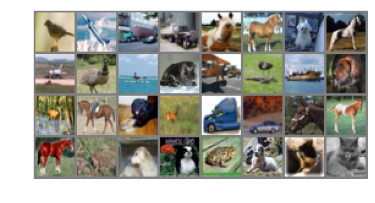

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [7]:
class_labels = []
for j in range(batch_size):
    class_labels.append(classes[labels[j]])
print(f"batchsize = {batch_size}\n")
print(str(class_labels)[1:-1]) 

batchsize = 32

'bird', 'plane', 'truck', 'truck', 'horse', 'horse', 'dog', 'horse', 'plane', 'bird', 'plane', 'cat', 'plane', 'bird', 'ship', 'dog', 'deer', 'horse', 'dog', 'deer', 'truck', 'car', 'horse', 'horse', 'horse', 'frog', 'dog', 'dog', 'frog', 'dog', 'cat', 'cat'


## 2.2 Distribution of the classes

In [8]:
dataiter_full = iter(fullloader)
images_full, labels_full = dataiter_full.next()
labels_full = labels_full.detach().cpu().numpy()

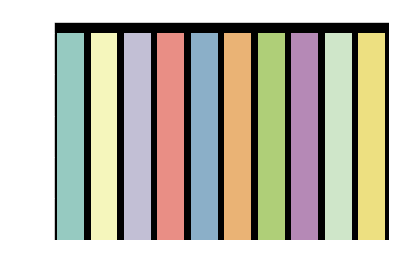

In [9]:
plot1 = sns.countplot(x=labels_full)
plot1 = plot1.set(xlabel='classes', ylabel='count',title='Distribution of Classes in CIFAR-10')
plt.show()

#### Balanced Data
You see that the distribution ot the classes in the dataset is almost perfect balanced. In normal cases this will not be the case, but the ciafa-10 dataset is a made extra for training with neuronal nets. 

In [10]:
df_describe = pd.DataFrame(labels_full)
#count the labels with Counter()
distro = collections.Counter(labels_full)

for i in range(len(distro.keys())):
    print(f"Label {i+1} has {distro[i]} Datapoints")

Label 1 has 5000 Datapoints
Label 2 has 5000 Datapoints
Label 3 has 5000 Datapoints
Label 4 has 5000 Datapoints
Label 5 has 5000 Datapoints
Label 6 has 4999 Datapoints
Label 7 has 5000 Datapoints
Label 8 has 5000 Datapoints
Label 9 has 5000 Datapoints
Label 10 has 5000 Datapoints


In [11]:
def check_distro(arr):
    #indicates the average deviation of the mean value of the number of data points.
    distro = collections.Counter(arr)
    distro_mean = np.array(list(distro.values())).mean()
    counter = 0
    for i in distro.keys():
        counter+=distro[i]-distro_mean
    return counter/len(arr)


In [12]:
print(f"the average deviation is {check_distro(distro):.25f}")

the average deviation is 0.0000000000003637978807092


## 2. Structure Modeling
### 2.4. Metrics

The model is a classic classifier, which distinguishes classes. For this type of model there are a variety of possible metrics.These are:
- Precision
- accuracy
- recall
- F or F1 Score (from Precision and Accuracy)
- ROC Curve

Something important, which is not a metric, is the confusion matrix. Here you can see the concrete "wrongness" of the prediction. For example, if the data is very unevenly distributed (i.e. there is much more of one label than others), the normal Precision or Accuracy value can only be used with great caution. For example, if you have only 2 labels and one label is 80% represented in the data set, and you have an accuracy of 80%, the model may simply attribute everything to the more represented label. You can see all of this in the cofusion matrix.

However, since my data set is almost perfectly balanced, I don't have this problem. It is still possible that my predictions are unbalanced. Therefore it is important to find a balance between precision and accuracy. This is done with the help of the ROC curve, from which you can calculate the area under the curve with the AUC metric. 

### 2.5. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu ????????????
evaluieren. Wie sollen die Gewichte initialisiert werden?

### 2.6 GPU of CPU
Pytorch has a implemented method to calulate everithing with the help of the gpu power. To following code makes the variable: device, whitch will test if gpu is 

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda', index=0)


In [14]:
print(f"Used Grafic-Card is called : {torch.cuda.get_device_name(0)}""

'Tesla P100-PCIE-16GB'

### 2.7 Epochs
To define how many epochs the programm will make, for calculation, lets define a variable who sets every epochcount to the same.

In [15]:
epochs = 15

## 2.8 Implementing a complete training, testing and visualisation class

In [77]:
class MLP:
    def __init__(self):
        self.train_losses = []
        self.test_losses  = []
        
        self.train_acc    = []
        self.test_acc     = []
        
        self.train_max    = []
        
        self.test_f1     = []
        self.test_pr     = []
        self.test_re     = []
    
    def train(self, model, device, train_loader, optimizer, epoch,L1=None):
        #if the L1 variable is not None the train model will run without the L1 regularisation, the L1 value is 

        criterion = nn.CrossEntropyLoss()
        model.train()
        pbar = tqdm_notebook(train_loader)

        for batch_idx, (data, target) in enumerate(pbar):
            train_acc_t=[]
            # Laden des Datensatzes als Tensor in die GPU
            data, target = data.to(device), target.to(device)

            # Gradient nullen
            optimizer.zero_grad()

            # feed forward for the prediction 
            y_pred = model(data)

            # Calculate loss with Crossentropy(), witch already contains softmax
            loss = criterion(y_pred, target)

            # Adding code for L1 Regularisation
            if L1 is not None:
              l1_crit = nn.L1Loss()
              reg_loss = 0
              for param in model.parameters():
                  reg_loss += l1_crit(param,target=torch.zeros_like(param))
              loss += L1 * reg_loss
              self.train_losses.append(loss.item())

            else:
              self.train_losses.append(loss.item())

            # Backpropagation
            loss.backward()
            optimizer.step()
            # calculate the accuarcy ot the batch
            acc = MLP.accuary(y_pred,target,len(data))
            # Update pbar-tqdm
            pbar.set_description(desc= f' Batch_id={batch_idx}\nLoss={loss.item():0.2f}\nAccuracy={acc:0.2f}')
            # Update accuary_list
            train_acc_t.append(acc)
        #store the mean of the accuaries of all batches
        self.train_acc.append(sum(train_acc_t)/len(train_acc_t))
        self.train_max.append(max(train_acc_t))

        
        
    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        f1_temp = []
        pr_temp = []
        re_temp = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                # sum up batch loss
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                # get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)  
                correct += pred.eq(target.view_as(pred)).sum().item()
                f1pred = torch.reshape(pred, (-1,))
                f1_temp.append(f1_score(target.cpu(),f1pred.cpu(),average="micro"))
                pr_temp.append(precision_score(target.cpu(),f1pred.cpu(),average="micro"))
                re_temp.append(recall_score(target.cpu(),f1pred.cpu(),average="micro"))

                
        test_loss /= len(test_loader.dataset)
        self.test_losses.append(test_loss)


        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        self.test_acc.append(100. * correct / len(test_loader.dataset))
        self.test_f1.append(sum(f1_temp) / len(f1_temp))
        self.test_pr.append(sum(pr_temp) / len(pr_temp))
        self.test_re.append(sum(re_temp) / len(re_temp))
        
    @staticmethod
    def accuary(y_pred,target,length):
        correct = 0
        processed = 0
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        return (100*(correct/length))
            
        
    def visualizeMLP(self):
        if len(self.train_losses) == 0:
            return "no initialisation"
        else:
            fig, axs = plt.subplots(2, 2)
            fig.set_figheight(15)
            fig.set_figwidth(15)
            axs[0, 0].plot(range(len(self.test_acc)),self.test_acc)
            axs[0, 0].plot(range(len(self.train_acc)),self.train_acc)
            axs[0, 0].set_title('Test and Test Accuracy')
            axs[0, 0].set_xlabel('Epochs')
            axs[0, 0].set_ylabel('Accuracy in %')
            axs[0, 0].legend(["trainaccuary","testaccuracy"],loc="upper right")
            #just a 45° line
            axs[0, 1].plot(self.test_re,self.test_re,linestyle = 'dotted')
            axs[0, 1].plot(self.test_re,self.test_pr)
            axs[0, 1].set_aspect('equal', 'box')
            axs[0, 1].set_title('ROC')
            axs[0, 1].set_xlabel('Precision')
            axs[0, 1].set_ylabel('Recall')
            axs[0, 1].legend(["45Degreeline","Precision-Recall"],loc="upper right")
            axs[1, 0].plot(range(len(self.test_f1)),self.test_f1)
            axs[1, 0].set_title('f1-score')
            axs[1, 0].set_ylabel('f1 with average = micro')
            axs[1, 0].set_xlabel('Epochs')
            axs[1, 1].plot(range(len(self.test_losses)),self.test_losses)
            #axs[1, 1].plot(range(len(self.train_losses)),self.train_losses)
            axs[1, 1].set_title('Loss')
            axs[1, 1].set_ylabel('Crossentropyloss')            
            axs[1, 1].set_xlabel('Epochs')
        
    def train_model(self, epochs,model,reg=None,ext_opt=None,weight_decay=0.003, lr=0.01):
        L1= None
        if  ext_opt is not None:
            optimizer = ext_opt
        else: 
            if (reg==None):
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif (reg=="L1"):
                L1 = 0.00005
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif(reg=="L2"):
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=weight_decay)

        for epoch in range(epochs):
            print(f"Epoch:{epoch+1}/{epochs}")
            self.train(model, device, trainloader, optimizer, epochs,L1=L1)
            self.test(model, device, testloader)

## 3  Training with SGD, without REG, without Batchnormalisation
Task: <br>
Investigate different models of different complexity, which could be
could be suitable to solve the classification problem. Use Stochastic Gradient
Descent - without acceleration, without regularization (REG) and without batchnorm
(BN).
- a. For each model with given number of layers and units per layer perform a careful hyper-parameter tuning (learning rate, batch size). Make sure always make sure that the training is stable. For each training, remember the loss, the performance metric(s) incl. estimation error, the number of epochs used, the learning rate epochs, learning rate and batch size.
- b. Vary the number of layers and number of units per layer to achieve the best possible performance as possible. If CNNs (without transfer learning) are used as well also vary number of filters, kernel size, stride, padding.
- c. Summarize the results in an appropriate plot, make a synthesis and conclude which synthesis and conclude which model complexity seems to make the most sense to you. seems to you.

### 3.1 My First Network: NN
structure of the net :
1. NN Layer
2. NN Layer
3. NN Layer
4. NN Layer
5. NN Layer

In [73]:
# PYtorch class for neuronal net
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,2000)
        self.fc2 = nn.Linear(2000, 1200)
        self.fc3 = nn.Linear(1200, 600)
        self.fc4 = nn.Linear(600, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [74]:
modelNN =  NN().to(device)
summary(modelNN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2000]       6,146,000
            Linear-2                 [-1, 1200]       2,401,200
            Linear-3                  [-1, 600]         720,600
            Linear-4                   [-1, 84]          50,484
            Linear-5                   [-1, 10]             850
Total params: 9,319,134
Trainable params: 9,319,134
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 35.55
Estimated Total Size (MB): 35.59
----------------------------------------------------------------


In [78]:
#training
M1 = MLP()
M1.train_model(epochs,modelNN)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.3124, Accuracy: 5186/10000 (51.86%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.1327, Accuracy: 5315/10000 (53.15%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.1266, Accuracy: 5206/10000 (52.06%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5969, Accuracy: 5402/10000 (54.02%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0435, Accuracy: 5547/10000 (55.47%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.4369, Accuracy: 5509/10000 (55.09%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9079, Accuracy: 5484/10000 (54.84%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9707, Accuracy: 5464/10000 (54.64%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.3398, Accuracy: 5450/10000 (54.50%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7502, Accuracy: 5472/10000 (54.72%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3646, Accuracy: 5392/10000 (53.92%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3754, Accuracy: 5408/10000 (54.08%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.3113, Accuracy: 5448/10000 (54.48%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.6072, Accuracy: 5484/10000 (54.84%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -8.6151, Accuracy: 5591/10000 (55.91%)



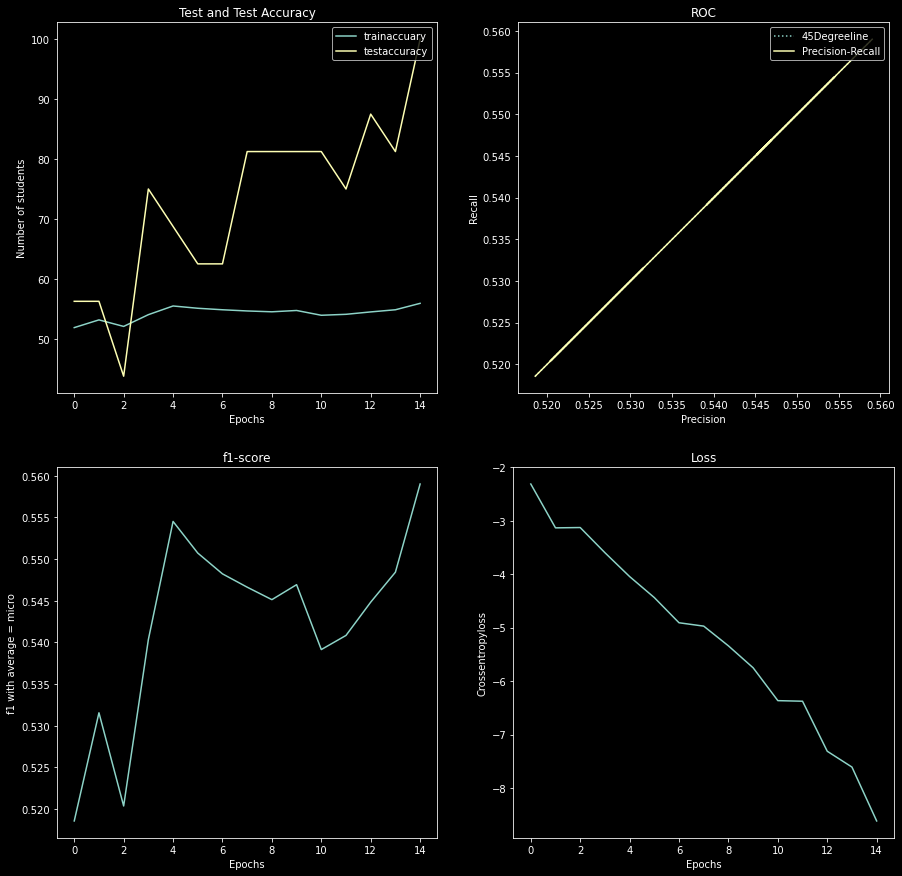

In [79]:
M1.visualizeMLP()

# 3.1.1 Evaluation of the Model
asdfjlka
sadfasdf

sadf

### 3.2 My First Convolutional Network : CNN1
structure of the net :
1. convolutional Layer
2. MxPooling
3. convolutional Layer
4. NN Layer
5. NN Layer
6. NN Layer

In [80]:
# PYtorch class for neuronal net
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [81]:
modelCNN1 =  CNN1().to(device)
summary(modelCNN1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [82]:
#training
#%%capture
M2 = MLP()
M2.train_model(epochs,modelCNN1)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.5021, Accuracy: 4718/10000 (47.18%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.4439, Accuracy: 5521/10000 (55.21%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4834, Accuracy: 5767/10000 (57.67%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.8039, Accuracy: 6009/10000 (60.09%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0395, Accuracy: 5821/10000 (58.21%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0153, Accuracy: 6151/10000 (61.51%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.1712, Accuracy: 5901/10000 (59.01%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.7382, Accuracy: 6002/10000 (60.02%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.7732, Accuracy: 6017/10000 (60.17%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9943, Accuracy: 5979/10000 (59.79%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9854, Accuracy: 6040/10000 (60.40%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.8845, Accuracy: 5980/10000 (59.80%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.5769, Accuracy: 6037/10000 (60.37%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.6005, Accuracy: 5941/10000 (59.41%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.8376, Accuracy: 5970/10000 (59.70%)



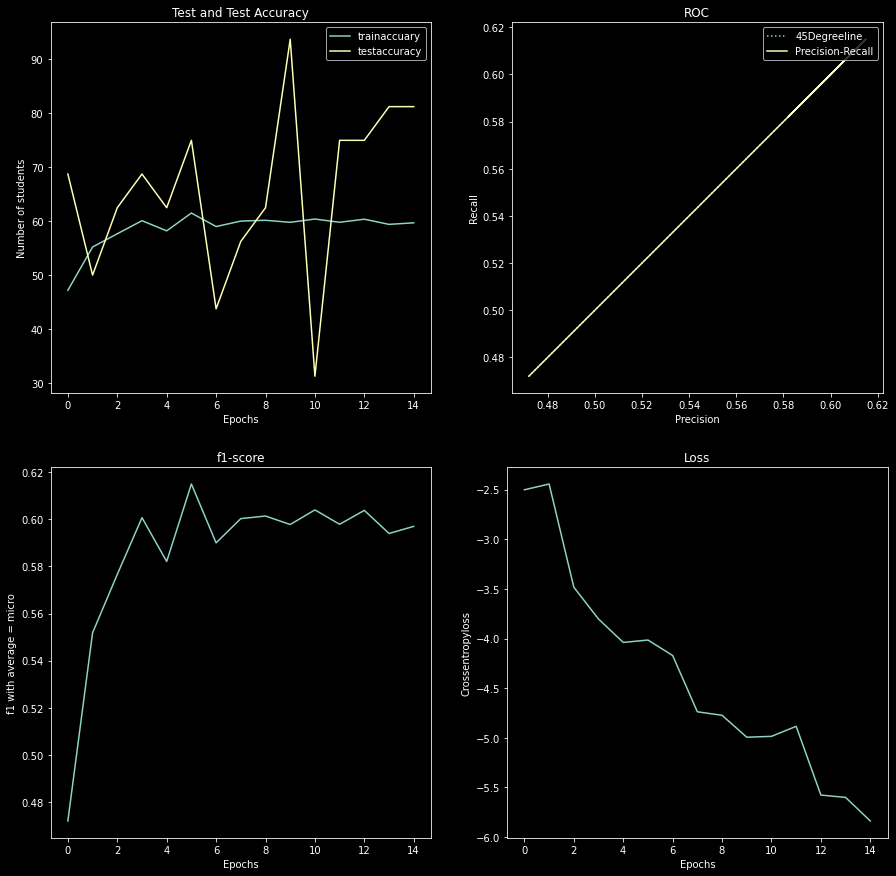

In [83]:
M2.visualizeMLP()

### # 3.2.1 Evaluation of the Model
asdfjlka
sadfasdf

sadf

## 4.0  Use of Regularization
- 4.1 L1 Weight Penalty
- 4.2 L2 Weight Penalty
- 4.3 Dropout

Task: <br>
Evaluate the benefit of the regularization, also taking into account the different
different regularization strengths. Also briefly describe what is the general goal of regularization
of regularization methods is (regularization in general, as well as the idea of
of the individual methods). To what extent is this goal achieved in the given case? 

### Model 4.1 - L1 regularisation

In [84]:
#%%capture
M3 = MLP()
M3.train_model(epochs,modelCNN1,reg="L1")

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3789, Accuracy: 6049/10000 (60.49%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.8517, Accuracy: 5828/10000 (58.28%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3193, Accuracy: 5991/10000 (59.91%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0712, Accuracy: 5863/10000 (58.63%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.9792, Accuracy: 5940/10000 (59.40%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.9735, Accuracy: 5922/10000 (59.22%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.9720, Accuracy: 5991/10000 (59.91%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6983, Accuracy: 5904/10000 (59.04%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.1049, Accuracy: 5951/10000 (59.51%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6055, Accuracy: 5835/10000 (58.35%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.1221, Accuracy: 5591/10000 (55.91%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6491, Accuracy: 5727/10000 (57.27%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.1091, Accuracy: 5846/10000 (58.46%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.5689, Accuracy: 5902/10000 (59.02%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.2319, Accuracy: 5819/10000 (58.19%)



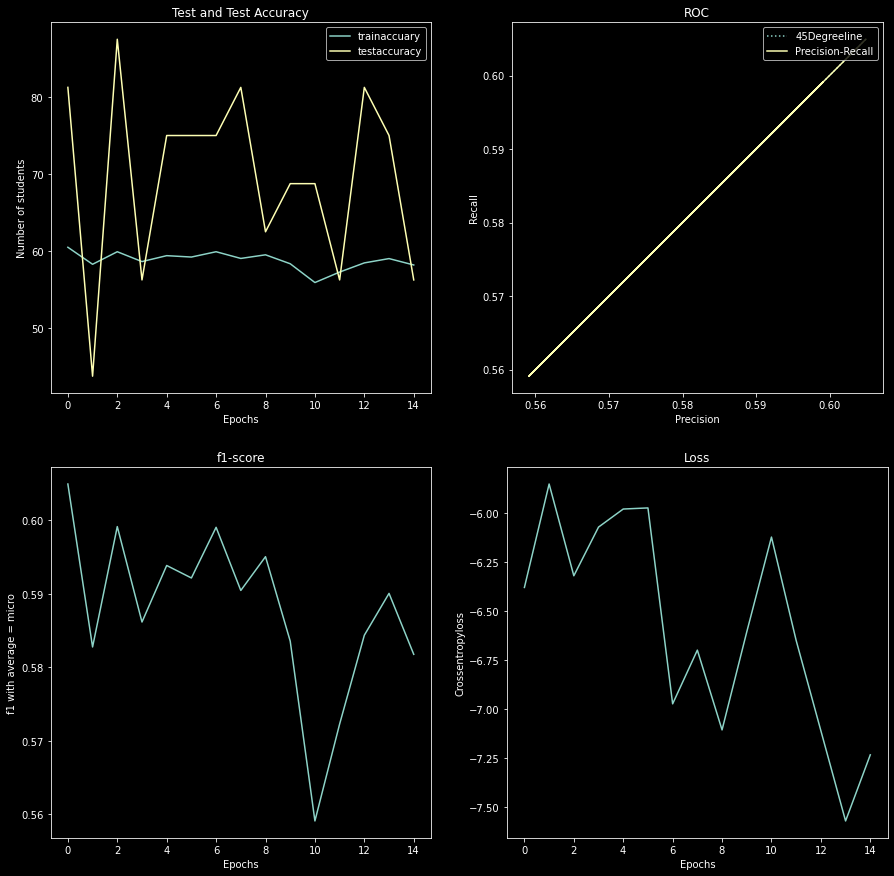

In [85]:
M3.visualizeMLP()

### 4.2.1 Evaluation of Model 4.2
asdf
asdf
asdf
asdf

### Model 4.2 - L2 regularisation

In [86]:
#%%capture
M4 = MLP()
M4.train_model(epochs,modelCNN1,reg="L2")

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.0590, Accuracy: 6045/10000 (60.45%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.8486, Accuracy: 6057/10000 (60.57%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5806, Accuracy: 5963/10000 (59.63%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4416, Accuracy: 5954/10000 (59.54%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.2187, Accuracy: 6145/10000 (61.45%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4998, Accuracy: 6247/10000 (62.47%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5662, Accuracy: 6022/10000 (60.22%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.6371, Accuracy: 6377/10000 (63.77%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4265, Accuracy: 6241/10000 (62.41%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4418, Accuracy: 6118/10000 (61.18%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5028, Accuracy: 6017/10000 (60.17%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5594, Accuracy: 6230/10000 (62.30%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.6770, Accuracy: 6279/10000 (62.79%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.7219, Accuracy: 6216/10000 (62.16%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.8285, Accuracy: 6434/10000 (64.34%)



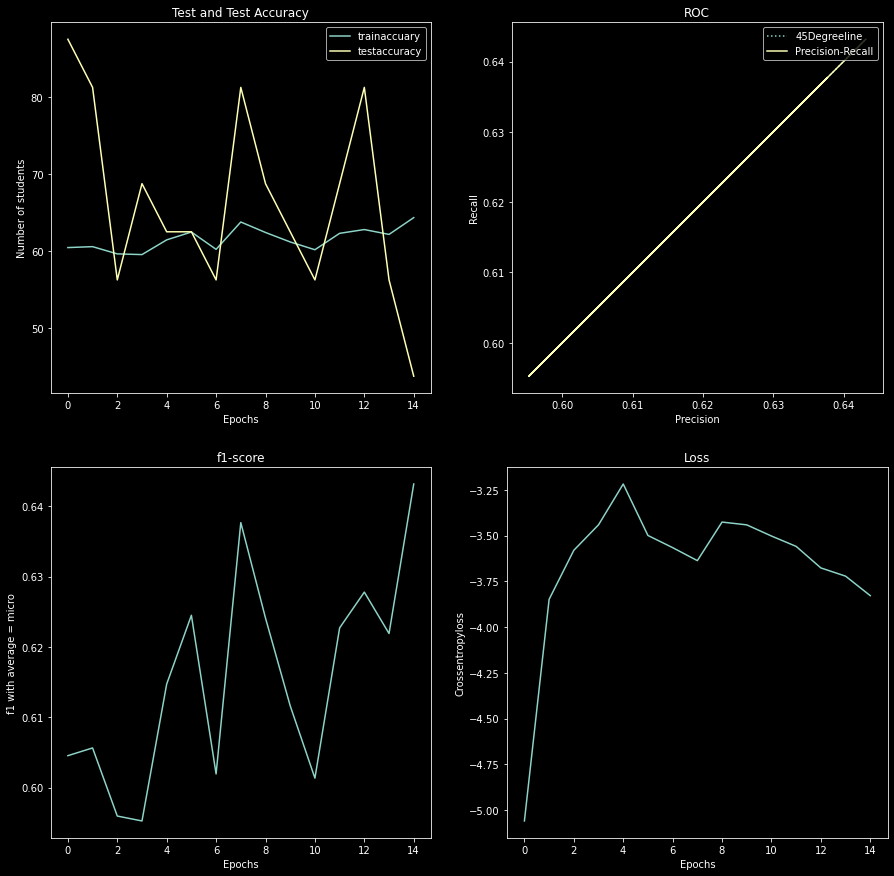

In [87]:
M4.visualizeMLP()

### 4.2.1 Evaluation of Model 4.2

## Model 4 -Drop Out
with Probability of 0.25

In [88]:
class NetDropOut(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [89]:
netdropout = NetDropOut()
netdropout.to(device)
model_drop = NetDropOut().to(device)

In [90]:
M5 = MLP()
M5.train_model(epochs,model_drop)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.0813, Accuracy: 4861/10000 (48.61%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.4728, Accuracy: 5027/10000 (50.27%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5607, Accuracy: 5798/10000 (57.98%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.2469, Accuracy: 5536/10000 (55.36%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.8375, Accuracy: 5848/10000 (58.48%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.9002, Accuracy: 6089/10000 (60.89%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.5578, Accuracy: 6233/10000 (62.33%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.8068, Accuracy: 6104/10000 (61.04%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.7928, Accuracy: 6139/10000 (61.39%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.2284, Accuracy: 6067/10000 (60.67%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7630, Accuracy: 6298/10000 (62.98%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.5815, Accuracy: 6204/10000 (62.04%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.5242, Accuracy: 6153/10000 (61.53%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0909, Accuracy: 6152/10000 (61.52%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)



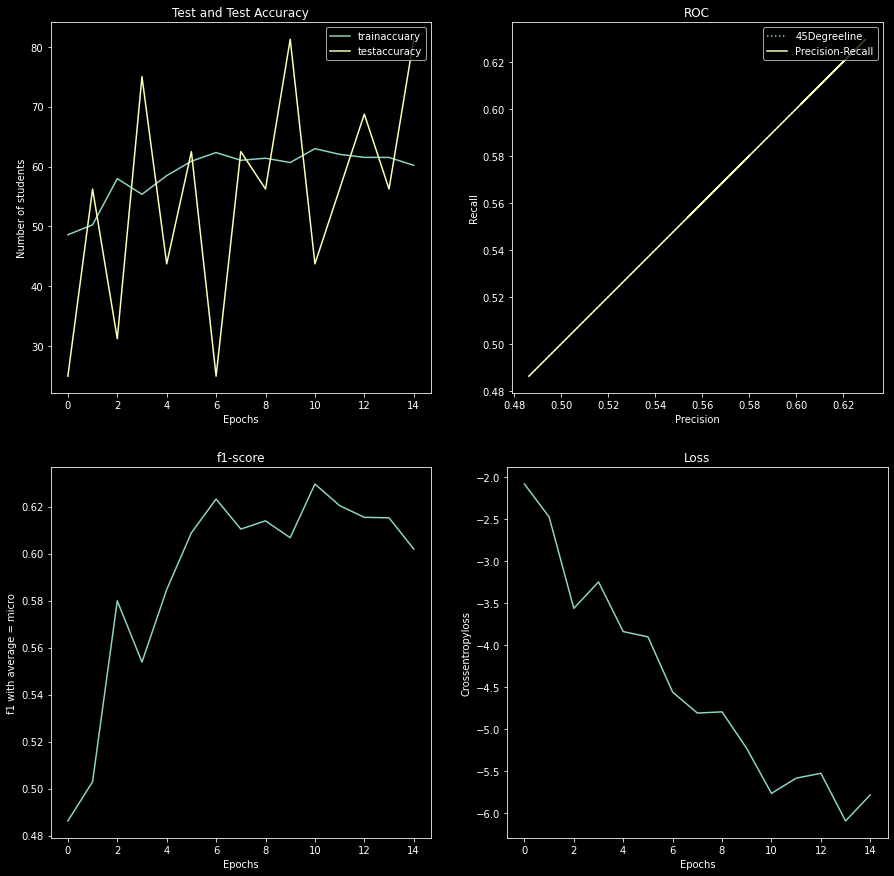

In [91]:
M5.visualizeMLP()

### Different Probability for the DropOut => 0.8

In [92]:
class NetDropOut2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [93]:
netdropout2 = NetDropOut2()
netdropout2.to(device)
model_drop2 = NetDropOut().to(device)

In [94]:
M5_5 = MLP()
M5_5.train_model(epochs,model_drop2)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -1.8265, Accuracy: 4580/10000 (45.80%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.5608, Accuracy: 5316/10000 (53.16%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.9158, Accuracy: 5718/10000 (57.18%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.6176, Accuracy: 6000/10000 (60.00%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.7696, Accuracy: 5976/10000 (59.76%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.9915, Accuracy: 6012/10000 (60.12%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0178, Accuracy: 6092/10000 (60.92%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.6375, Accuracy: 6293/10000 (62.93%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.6880, Accuracy: 6166/10000 (61.66%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.1297, Accuracy: 6201/10000 (62.01%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.1871, Accuracy: 6209/10000 (62.09%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7017, Accuracy: 6295/10000 (62.95%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.2078, Accuracy: 6251/10000 (62.51%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7439, Accuracy: 6164/10000 (61.64%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.6488, Accuracy: 6220/10000 (62.20%)



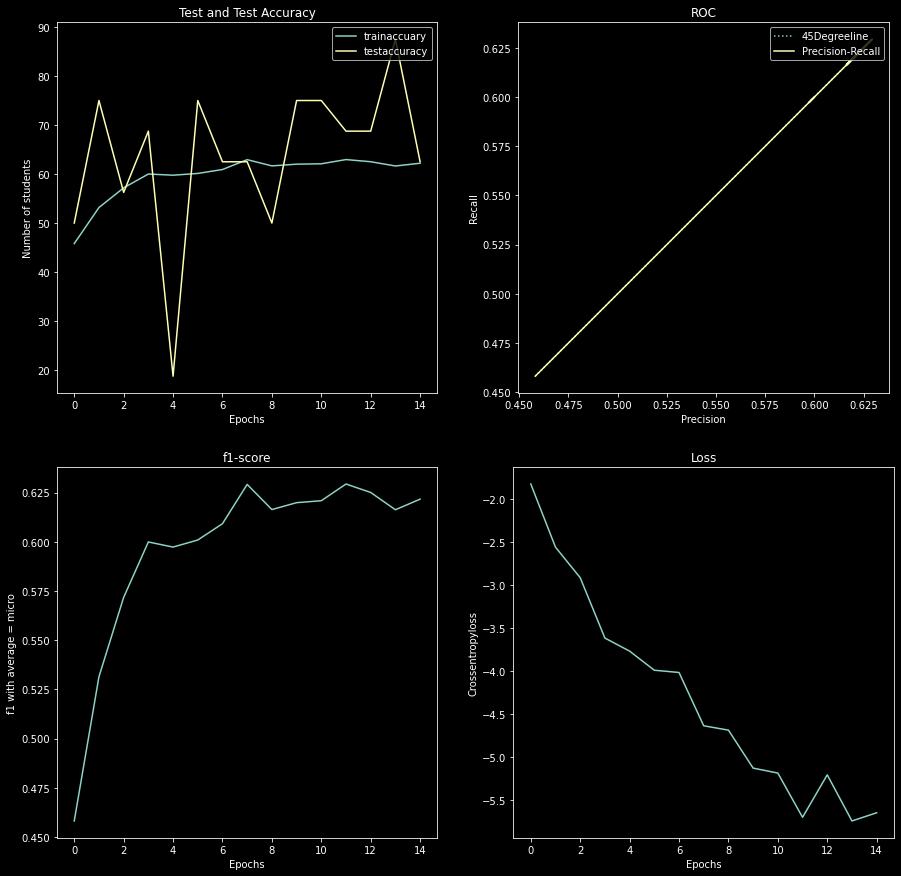

In [95]:
M5_5.visualizeMLP()

## Schritt 5: Nutzen von Batchnorm BN (ohne REG, mit SGD)
9. Evaluiere, ob Batchnorm etwas bringt. Beschreibe kurz, was die Idee von BN ist,
wozu es helfen soll.

In [96]:
class NetbN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels= 6,kernel_size= 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bN1  = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bN1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [97]:
netbN = NetbN()
netbN.to(device)
model_bN = NetbN().to(device)
summary(model_bN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
       BatchNorm2d-5             [-1, 16, 5, 5]              32
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 62,038
Trainable params: 62,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [98]:
M6 = MLP()
M6.train_model(epochs,model_bN)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.8546, Accuracy: 5365/10000 (53.65%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5752, Accuracy: 5916/10000 (59.16%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.5445, Accuracy: 6055/10000 (60.55%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0482, Accuracy: 6216/10000 (62.16%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.2345, Accuracy: 6384/10000 (63.84%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.1711, Accuracy: 6411/10000 (64.11%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9475, Accuracy: 6532/10000 (65.32%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.2757, Accuracy: 6568/10000 (65.68%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.4550, Accuracy: 6449/10000 (64.49%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.4489, Accuracy: 6411/10000 (64.11%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0983, Accuracy: 6551/10000 (65.51%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.1363, Accuracy: 6487/10000 (64.87%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6095, Accuracy: 6468/10000 (64.68%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6666, Accuracy: 6491/10000 (64.91%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.4751, Accuracy: 6489/10000 (64.89%)



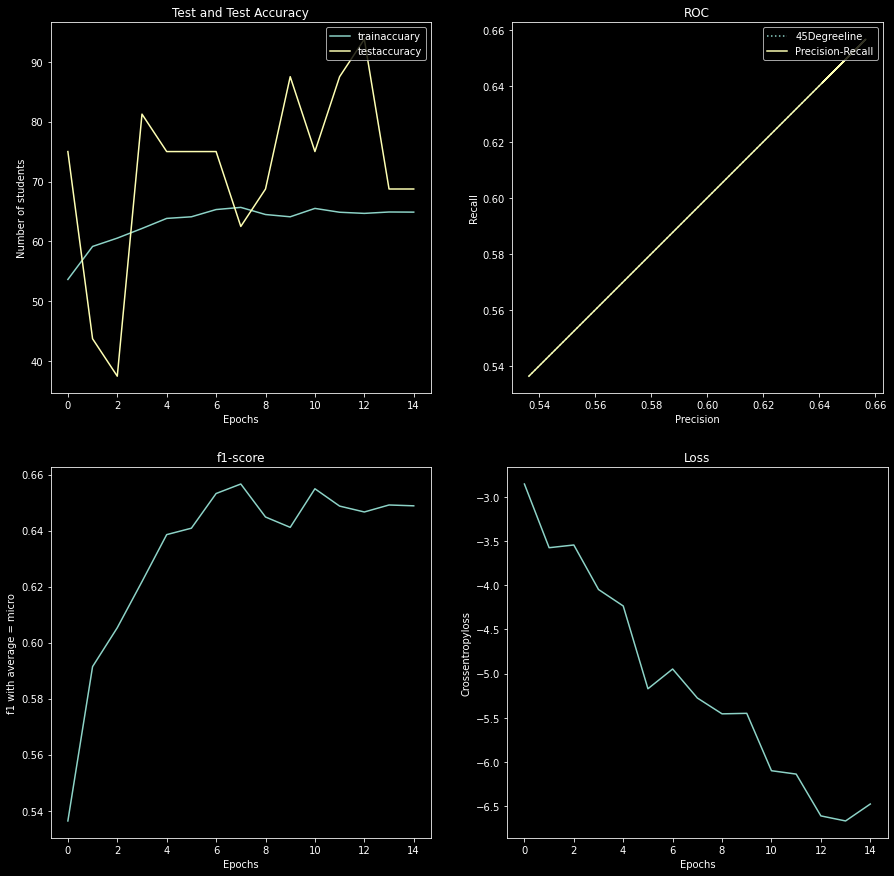

In [99]:
M6.visualizeMLP()

In [100]:
class NetbN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4*4*256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool1(self.relu1(x))
        x = self.bn2(self.conv2(x))
        x = self.pool2(self.relu2(x))
        x = self.bn3(self.conv3(x))
        x = self.pool3(self.relu3(x))
        s = x.view((x.shape[0], -1))
        s = self.fc1(s)
        s = self.fc2(s)
        s = self.fc3(s)
        return s

In [101]:
netbN2 = NetbN2()
netbN2.to(device)
model_bN2 = NetbN2().to(device)
summary(model_bN2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                  [-1, 128]         524,416
           Linear-14                   

In [102]:
M7 = MLP()
M7.train_model(epochs,model_bN2)


Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.2610, Accuracy: 6128/10000 (61.28%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.0484, Accuracy: 6866/10000 (68.66%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.8421, Accuracy: 7353/10000 (73.53%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0502, Accuracy: 7524/10000 (75.24%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.4288, Accuracy: 7352/10000 (73.52%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -8.5732, Accuracy: 7777/10000 (77.77%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -9.1136, Accuracy: 7828/10000 (78.28%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -10.1427, Accuracy: 7691/10000 (76.91%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -11.0640, Accuracy: 7745/10000 (77.45%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -12.2124, Accuracy: 7655/10000 (76.55%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.6888, Accuracy: 7890/10000 (78.90%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -14.1219, Accuracy: 7718/10000 (77.18%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -14.1500, Accuracy: 7808/10000 (78.08%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -15.2522, Accuracy: 7827/10000 (78.27%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2291, Accuracy: 7894/10000 (78.94%)



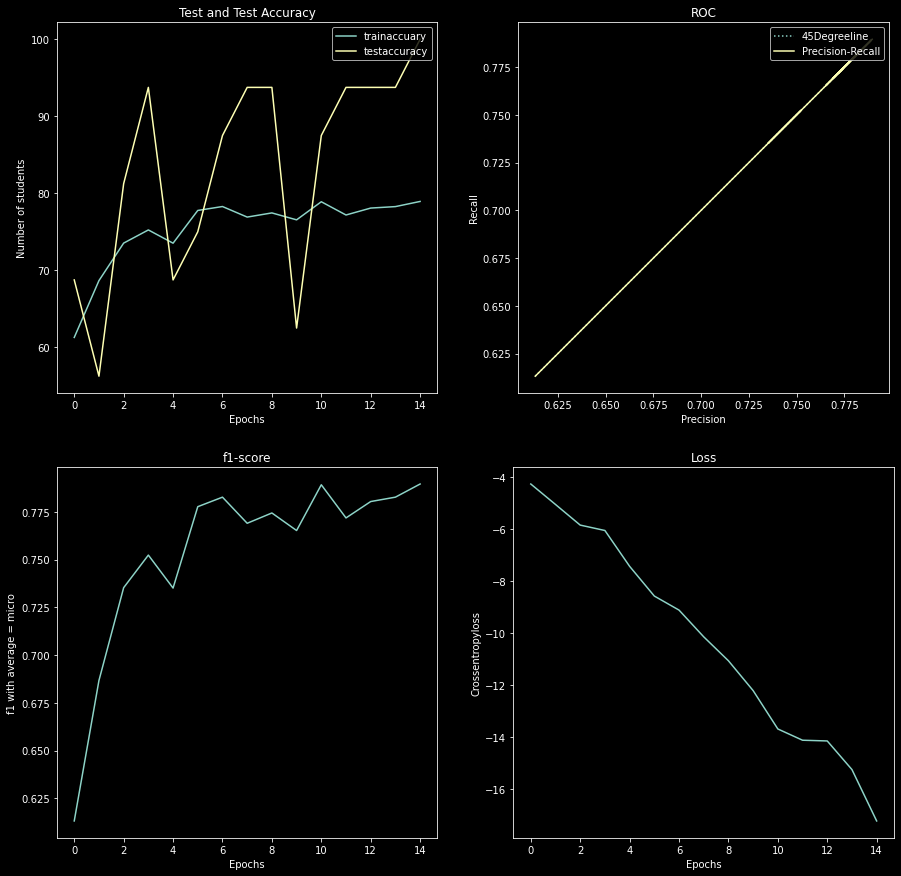

In [103]:
M7.visualizeMLP()

## Schritt 6: Nutzen von Adam (ohne BN, ohne / mit REG)
10. Evaluiere, ob Du mit Adam bessere Resultate erzielen kannst.
11. Versuche den erreichten / nicht erreichten Nutzen zu interpretieren.

In [104]:
#Adam optimizer
AdamAlpha = 0.0001
optimizerADAM  = optim.Adam(modelCNN1.parameters(), AdamAlpha)
optimizerADAMW = optim.AdamW(modelCNN1.parameters(),weight_decay=0.1)

In [105]:
#without regression
#%%capture
M8 = MLP()
M8.train_model(epochs,modelCNN1,ext_opt = optimizerADAM)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.7202, Accuracy: 6917/10000 (69.17%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9964, Accuracy: 6965/10000 (69.65%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.1246, Accuracy: 6966/10000 (69.66%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.1821, Accuracy: 6988/10000 (69.88%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.2562, Accuracy: 6950/10000 (69.50%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.4205, Accuracy: 6957/10000 (69.57%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.5626, Accuracy: 6938/10000 (69.38%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.6233, Accuracy: 6961/10000 (69.61%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7473, Accuracy: 6904/10000 (69.04%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.8775, Accuracy: 6907/10000 (69.07%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0383, Accuracy: 6907/10000 (69.07%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.0856, Accuracy: 6901/10000 (69.01%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.2278, Accuracy: 6901/10000 (69.01%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3948, Accuracy: 6887/10000 (68.87%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.3672, Accuracy: 6862/10000 (68.62%)



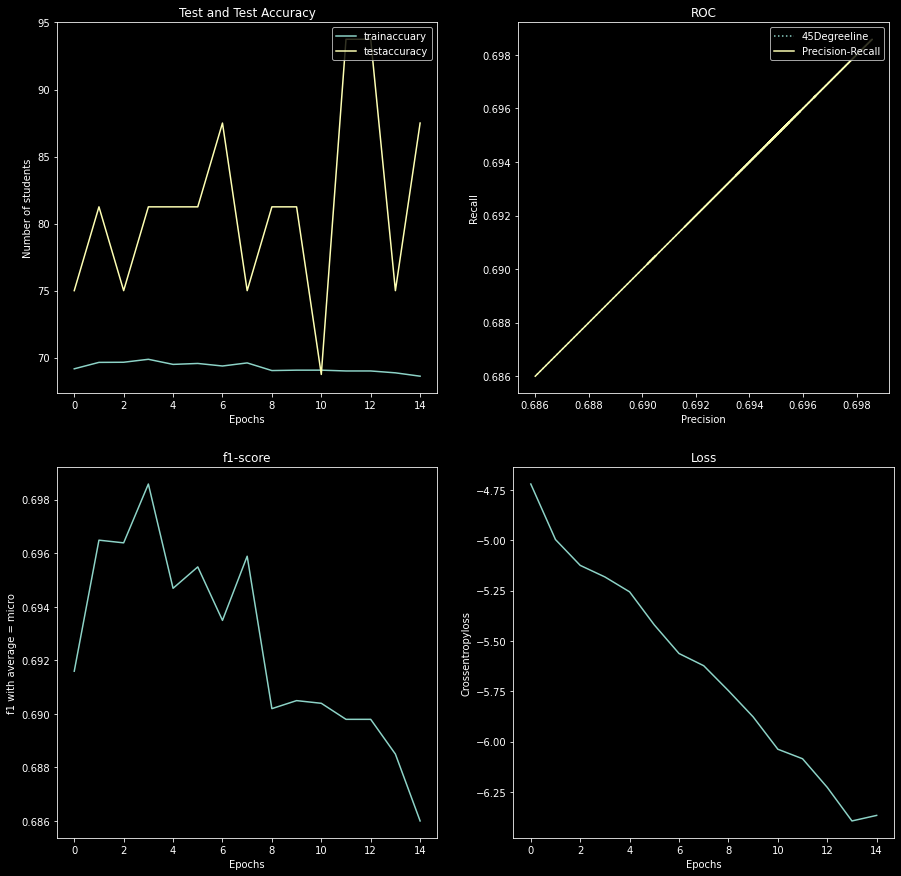

In [106]:
M8.visualizeMLP()

In [107]:
#with l2 regression
M9 = MLP()
M9.train_model(epochs,modelCNN1,ext_opt = optimizerADAMW)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0045, Accuracy: 6777/10000 (67.77%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.7877, Accuracy: 6727/10000 (67.27%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.4693, Accuracy: 6682/10000 (66.82%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.2509, Accuracy: 6815/10000 (68.15%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.0698, Accuracy: 6699/10000 (66.99%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -3.0684, Accuracy: 6759/10000 (67.59%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.7509, Accuracy: 6710/10000 (67.10%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.8755, Accuracy: 6725/10000 (67.25%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.6846, Accuracy: 6690/10000 (66.90%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.6403, Accuracy: 6788/10000 (67.88%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.4151, Accuracy: 6750/10000 (67.50%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.5133, Accuracy: 6751/10000 (67.51%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.5149, Accuracy: 6730/10000 (67.30%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.5603, Accuracy: 6743/10000 (67.43%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -2.3135, Accuracy: 6740/10000 (67.40%)



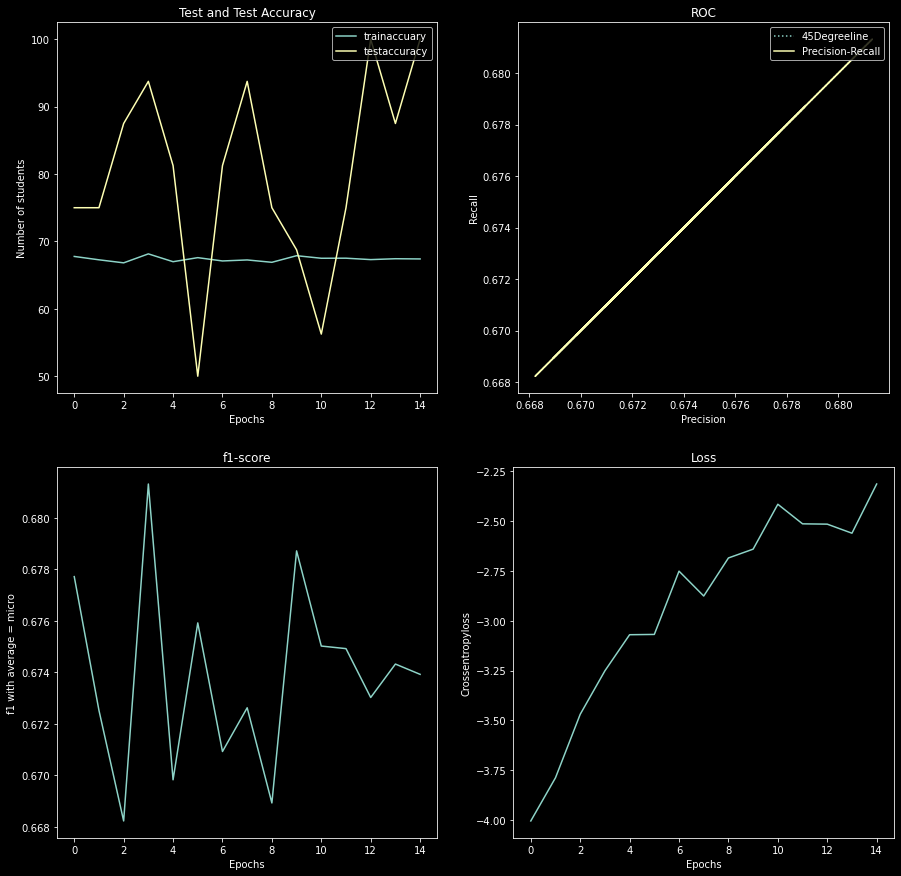

In [108]:
M9.visualizeMLP()

In [109]:
#Adam with batchnormalisation
M10 = MLP()
M10.train_model(epochs,model_bN2,ext_opt = optimizerADAM)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.1849, Accuracy: 7925/10000 (79.25%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.4790, Accuracy: 7921/10000 (79.21%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.0669, Accuracy: 7930/10000 (79.30%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.0748, Accuracy: 7915/10000 (79.15%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.9554, Accuracy: 7926/10000 (79.26%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.0885, Accuracy: 7916/10000 (79.16%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.8859, Accuracy: 7903/10000 (79.03%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.9348, Accuracy: 7908/10000 (79.08%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.8505, Accuracy: 7904/10000 (79.04%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.3935, Accuracy: 7915/10000 (79.15%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.5394, Accuracy: 7931/10000 (79.31%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.1464, Accuracy: 7916/10000 (79.16%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.4721, Accuracy: 7908/10000 (79.08%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.1417, Accuracy: 7908/10000 (79.08%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2659, Accuracy: 7920/10000 (79.20%)



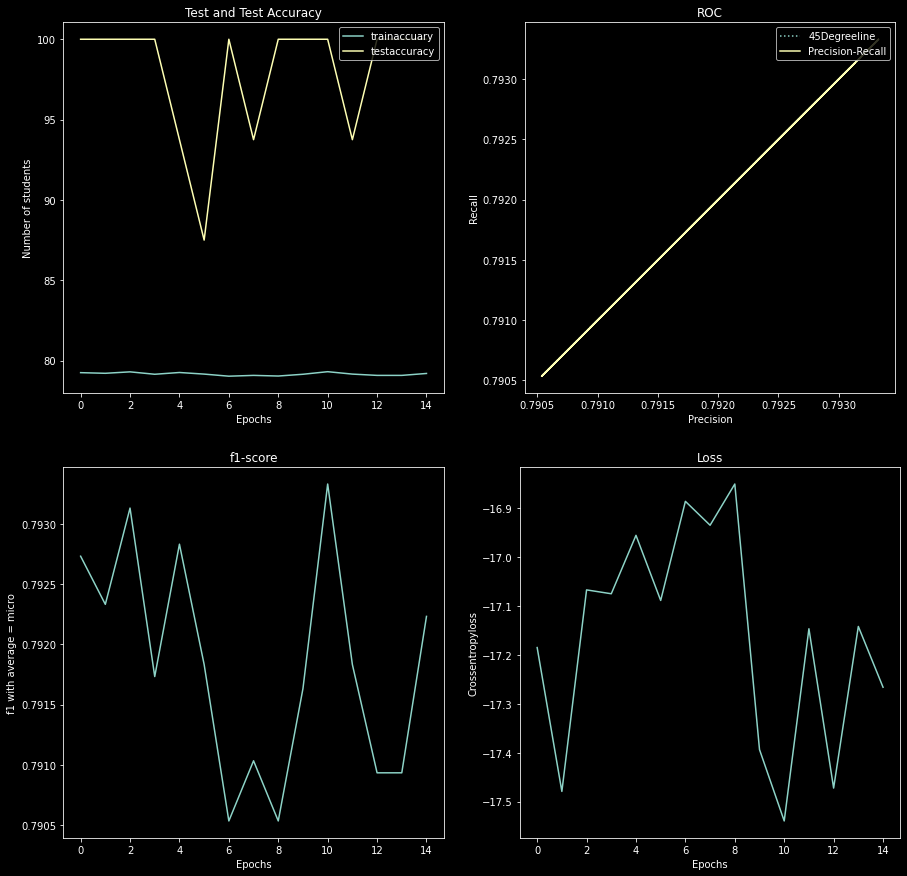

In [110]:
M10.visualizeMLP()

In [111]:
#batchnormalisation with L2 Regularisation
M11 = MLP()
M11.train_model(epochs,model_bN2,ext_opt = optimizerADAMW)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2457, Accuracy: 7903/10000 (79.03%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.9236, Accuracy: 7912/10000 (79.12%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.1750, Accuracy: 7922/10000 (79.22%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.3694, Accuracy: 7913/10000 (79.13%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2742, Accuracy: 7915/10000 (79.15%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.0481, Accuracy: 7923/10000 (79.23%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.9788, Accuracy: 7913/10000 (79.13%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.0308, Accuracy: 7908/10000 (79.08%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.5127, Accuracy: 7900/10000 (79.00%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -16.9621, Accuracy: 7915/10000 (79.15%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2099, Accuracy: 7917/10000 (79.17%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.3039, Accuracy: 7922/10000 (79.22%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.3528, Accuracy: 7922/10000 (79.22%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.2694, Accuracy: 7918/10000 (79.18%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -17.3117, Accuracy: 7922/10000 (79.22%)



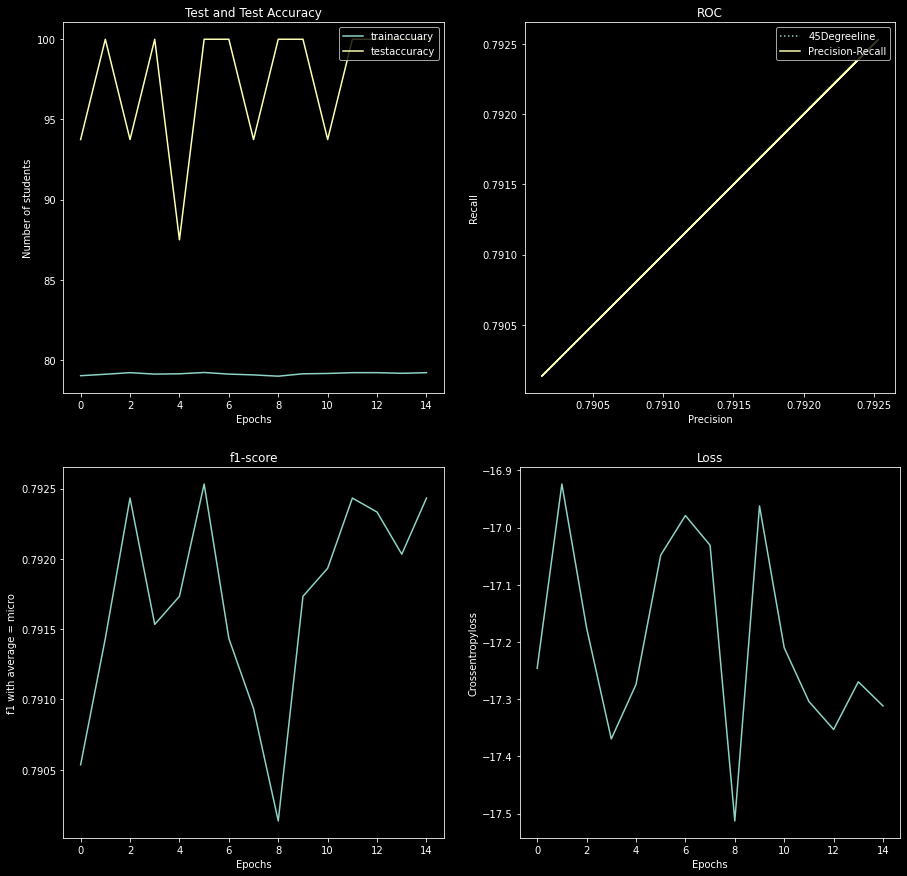

In [112]:
M11.visualizeMLP()

In [113]:
#dropout model with Adam
M12 = MLP()
M12.train_model(epochs,model_drop,ext_opt = optimizerADAM)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.7804, Accuracy: 6020/10000 (60.20%)



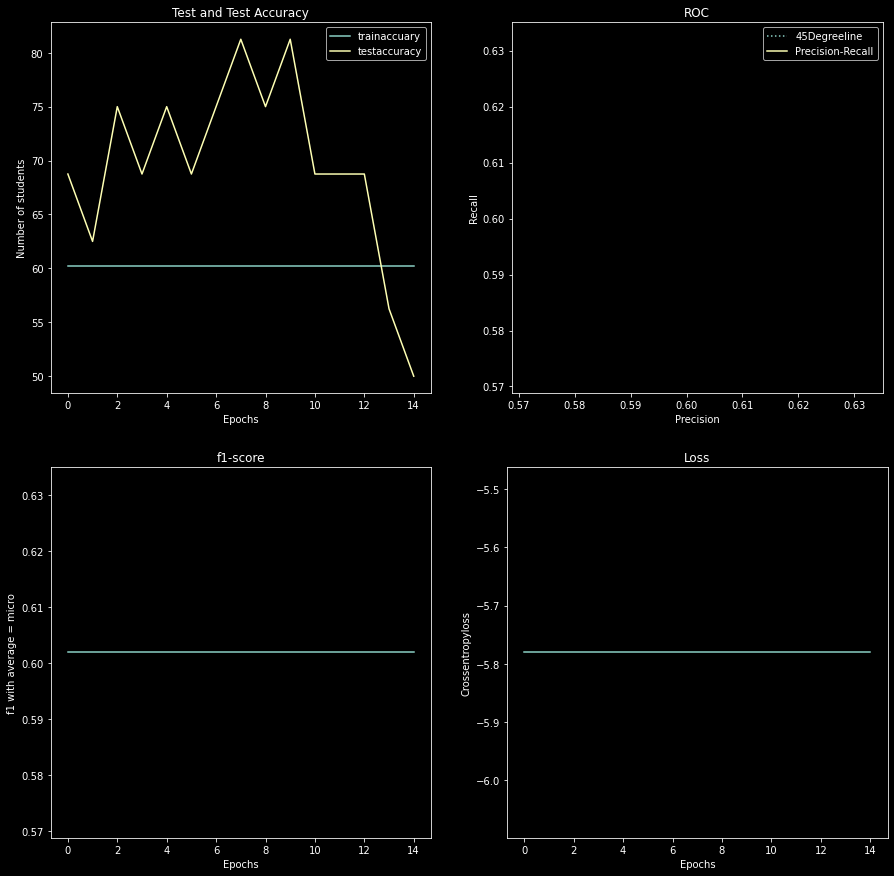

In [114]:
M12.visualizeMLP()

In [153]:
class NetbN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4*4*256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
        self.drop= nn.Dropout(0.6)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool1(self.relu1(x))
        x = self.bn2(self.conv2(x))
        x = self.pool2(self.relu2(x))
        x = self.bn3(self.conv3(x))
        x = self.pool3(self.relu3(x))
        s = x.view((x.shape[0], -1))
        s = self.fc1(s)
        s = self.drop(s)
        s = self.fc2(s)
        s = self.fc3(s)
        return s

In [154]:
netbN3 = NetbN3()
netbN3.to(device)
model_bN3 = NetbN3().to(device)
summary(model_bN3, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                  [-1, 128]         524,416
          Dropout-14                  [

In [155]:
MX = MLP()
MX.train_model(epochs,model_bN3)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.0508, Accuracy: 5849/10000 (58.49%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -4.9424, Accuracy: 6755/10000 (67.55%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -5.5241, Accuracy: 7376/10000 (73.76%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -6.6171, Accuracy: 7610/10000 (76.10%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -7.2162, Accuracy: 7706/10000 (77.06%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -8.5328, Accuracy: 7783/10000 (77.83%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -8.0038, Accuracy: 7880/10000 (78.80%)

Epoch:8/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -9.0731, Accuracy: 7836/10000 (78.36%)

Epoch:9/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -9.1803, Accuracy: 7845/10000 (78.45%)

Epoch:10/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -9.8949, Accuracy: 7895/10000 (78.95%)

Epoch:11/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -11.6181, Accuracy: 7980/10000 (79.80%)

Epoch:12/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.0547, Accuracy: 8024/10000 (80.24%)

Epoch:13/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.3139, Accuracy: 7934/10000 (79.34%)

Epoch:14/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -11.2853, Accuracy: 7842/10000 (78.42%)

Epoch:15/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.8054, Accuracy: 7851/10000 (78.51%)



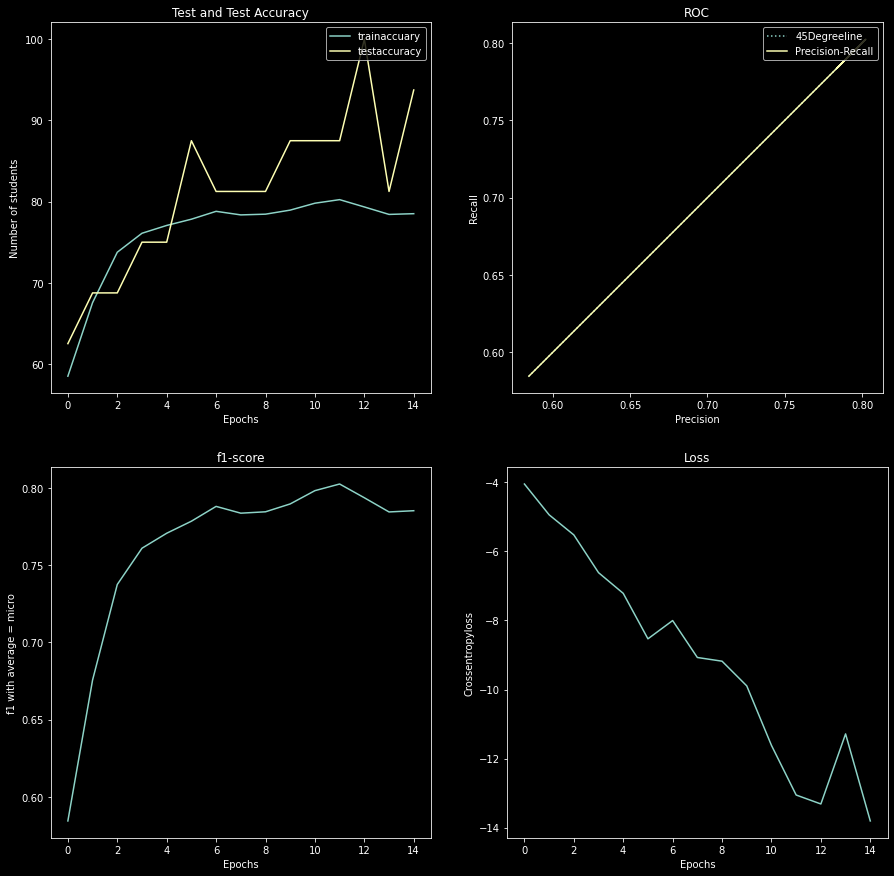

In [156]:
MX.visualizeMLP()

In [ ]:
MXX = MLP()
MXX.train_model(epochs,model_bN3,ext_opt=optimizerADAM)

Epoch:1/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -14.0765, Accuracy: 7919/10000 (79.19%)

Epoch:2/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.2939, Accuracy: 7931/10000 (79.31%)

Epoch:3/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.5866, Accuracy: 7928/10000 (79.28%)

Epoch:4/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.9975, Accuracy: 7935/10000 (79.35%)

Epoch:5/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.5319, Accuracy: 7930/10000 (79.30%)

Epoch:6/15


  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: -13.6433, Accuracy: 7926/10000 (79.26%)

Epoch:7/15


  0%|          | 0/1563 [00:00<?, ?it/s]

In [ ]:
MXX.visualizeMLP()